# Assignment 3

**Virtual Personal Assistant**: *Siri*

In [120]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import imgkit
import io
import sys
import base64
from colour import Color
import collections

import statsmodels.api as sm
import statsmodels.formula.api import smp
from scipy import stats

from pandas_profiling import ProfileReport

import qgrid

import spacy
from spacy import displacy
# import en_core_web_md # en_core_web_sm, en_core_web_md, en_core_web_lg
# NLP = en_core_web_md.load()
# NLP = spacy.load("en_core_web_md")
# from spacy_readability import Readability
# from dframcy import DframCy
# NLP.add_pipe(Readability())

import us as united_states
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


# from spacy.matcher import Matcher
# matcher = Matcher(NLP.vocab)

import warnings
warnings.filterwarnings("ignore")  #<!==To hide Seaborn warnings==!

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

pd.options.display.max_rows     = None
pd.options.display.max_columns  = None

SyntaxError: invalid syntax (<ipython-input-120-c0bdb3bcd3c0>, line 15)

## Data Collection & Standardization

In [6]:
class DataPrep:
    
    def __init__(self):
        
        self.df_raw = self._import_Responses()
        self.df_questions = self._make_questionGuide(self.df_raw)
        self.df_AudioData = pd.read_csv("AudioData.csv").set_index('column_text')
        
        self.dfAnswers = self._BuildAnswerDfs(self.df_raw, self.df_questions)
        
        self.dfSummary = self._getSummary()
        
        self._analyzePhonetic = self._AnalyzePhonetics()
            
    def _import_Responses(self):
        #dfcsv = pd.read_csv("Assignment3_Responses.csv")
        dfxls = pd.read_excel("Assignment3_Responses.xlsx")
        self.dict_vpaAnswers = pd.read_excel("ResponseAnswers_VPA.xlsx").set_index('question')['answer_VPA'].to_dict()
        
        return dfxls
    
    def _make_questionGuide(self, df_raw_responses):
        list_questions = list(df_raw_responses.columns[4:])
        questions = []
        for q in list_questions:
            group_split = q.split(': ')
            group_NumType = group_split[0].split(', ')
            groupNum = group_NumType[0].split(' ')[-1]
            groupType = group_NumType[1:]

            question = group_split[1]
            q_num     = re.search(r'\((.*?)\)', question).group(1)
            q_answer  = re.search(r'\[(.*?)\]', question).group(1)
            question_phoenetic = question.replace(str('('+q_num+')'), '').replace(str('['+q_answer+']'),'').strip()
            country_phoenetic = question_phoenetic.replace("What's the capital of ","").replace("?","").strip()
            question_actual = "What's the capital of " + q_answer + "?"
            
            questions.append({
                'question_number' : q_num,
                'column_text'   : q,
                'group_number'  : groupNum,
                'group_type'    : groupType,
                'question_phoenetic' : question_phoenetic,
                'question_actual' : question_actual,
                'country_actual' : q_answer,
                'country_phoenetic' : country_phoenetic,
            })
        
        df = pd.DataFrame(questions)
        df['group_subtype']  = df['group_type'].apply(lambda x: x[1] if len(x)>1 else np.nan)
        df['group_type']     = df['group_type'].apply(lambda x: x[0])
        
        df = df.astype({
            'question_number' :'int64',
            'group_number'    :'category',
            'group_type'      :'category',
            'group_subtype'   :'category',
        })
        
        df = df.sort_values(by=['question_number'])[[  # Ordering columns
            'column_text',
            'question_number',
            'group_number',
            'group_type',
            'group_subtype',
            'question_phoenetic',
            'question_actual',
            'country_phoenetic',
            'country_actual'
        ]]
        
        df['country_actual'] = np.where(df['country_actual']=="'There is no such country'","There is no such country", df['country_actual'])
        df['country_actual'] = np.where(df['country_actual']=="No distortion", df['country_phoenetic'], df['country_actual'])
        
        self.dict_correct = pd.read_csv("Correct_Country2Capital.csv").drop_duplicates(subset=['Country'], keep=False).set_index('Country')['Capital'].to_dict()
        df['answer'] = df['country_actual'].apply(lambda x: self.dict_correct.get(x))
        
        df['answer'] = np.where(df['country_actual']=="There is no such country", "There is no such country", df['answer'])
        
        return df
    
    def _BuildAnswerDfs(self, responses_dataframe, questions_dataframe):
        '''Creates DataFrames to analyze specific contexts.
            
            DataFrame Types
            ---------------
                Answer-based --> ***use ``Correct_Country2Capital.csv``***
                    - Either correct (1) or incorrect (0)
                    - Important for acting as a control
                Belief of country's existence
                    - 1: Any response other than "There is no such country"
                    - 0: "There is no such country"
                
            Returns
            -------        
        '''        
        ##--Filtering out questions only--##
        RF = responses_dataframe.iloc[:,4:]
        QF = questions_dataframe.reset_index()
        self.RF, self.QF = RF, QF
        
        self.q_col2correctCountry = QF.set_index('column_text')['country_actual'].to_dict()
        ####====Answer Correct====####
        df = RF.copy()
        
        dict_AnswerCorrect = dict((k,list(1 if ((self.dict_correct.get(self.q_col2correctCountry.get(k))==i) or ((i=="There is no such country") and (self.dict_correct.get(self.q_col2correctCountry.get(k))==None))) else 0 for i in v)) for k,v in RF.to_dict('list').items())
        self.dfScore = pd.DataFrame(dict_AnswerCorrect)
        
        q2mean_AnswerCorrect = self.dfScore.mean()
        
        ####====Country Exists====####
        df = RF.copy()
        
        dict_CountryExists = dict((k,list(1 if i!="There is no such country" else 0 for i in v)) for k,v in RF.to_dict('list').items())
        self.dfCountrtExists = pd.DataFrame(dict_CountryExists)
        
        q2mean_CountryExists = self.dfCountrtExists.mean()
        
        ####====VPA Answers====####
        dict_vpaCorrect = dict((k,1) if ((self.dict_correct.get(self.q_col2correctCountry.get(k))==v) or ((v=="There is no such country") and (self.dict_correct.get(self.q_col2correctCountry.get(k))==None))) else (k,0) for k,v in self.dict_vpaAnswers.items())
        self.dict_vpaCorrect = dict_vpaCorrect
        ####====VPA Country Exists====####
        dict_vpaCountryExists = dict((k,1) if v!="There is no such country" else (k,0) for k,v in self.dict_vpaAnswers.items())
        self.dict_vpaCountryExists = dict_vpaCorrect
        
    def _getSummary(self):
        
        dfq = self.QF.set_index('column_text')
        
        dfq['speech_DURATION'] = self.df_AudioData['DURATION']
        
        dfHum_correct = self.dfScore
        dfHum_exists  = self.dfCountrtExists
        serVPA_correct = pd.Series(self.dict_vpaCorrect)
        serVPA_exists  = pd.Series(self.dict_vpaCountryExists)
        
        dfq['Human_correct_mean']  = dfHum_correct.mean()
        dfq['Human_correct_std']   = dfHum_correct.std()
        dfq['VPA_correct']         = serVPA_correct
        
        dfq['Human_exists_mean']  = dfHum_exists.mean()
        dfq['Human_exists_std']   = dfHum_exists.std()
        dfq['VPA_exists']         = serVPA_exists
        
        dfq['Human_correct_normMean'] = (dfq['Human_correct_mean'] - min(dfq['Human_correct_mean'])) / (max(dfq['Human_correct_mean']) - min(dfq['Human_correct_mean']))        
        dfq['VPA_correct_normMean']  = (dfq['VPA_correct'] - min(dfq['VPA_correct'])) / (max(dfq['VPA_correct']) - min(dfq['VPA_correct']))        
        dfq['Human_exists_normMean'] = (dfq['Human_exists_mean'] - min(dfq['Human_exists_mean'])) / (max(dfq['Human_exists_mean']) - min(dfq['Human_exists_mean']))        
        dfq['VPA_exists_normMean'] = (dfq['VPA_exists'] - min(dfq['VPA_exists'])) / (max(dfq['VPA_exists']) - min(dfq['VPA_exists']))        
        
        
        return dfq
        
    def getNormalized(self, dataframe, target_columns=None, set_min_val=None, set_max_val=None):
        '''Normalizes values by column.
            
            Parameters
            ----------
                target_columns : list, `all`
                    - If a list is provided, it will normalize
                        each column in the list.
                    - If `all` is selected, all columns will
                        be normalized.
            Returns
            -------
                pd.DataFrame        
        '''
        if isinstance(dataframe, pd.DataFrame):
            if target_columns==None:
                return dataframe
            else:
                df = dataframe
                tcols = list(df.columns) if (target_columns==all) else target_columns

                for c in tcols:
                    if c in df.columns:
                        min_val = min(df[c]) if (set_min_val==None) else set_min_val
                        max_val = max(df[c]) if (set_max_val==None) else set_max_val
                        df[c] = (df[c] - min_val) / (max_val - min_val)
                return df
        elif isinstance(dataframe, pd.Series):
            ser = dataframe
            min_val = min(ser) if (set_min_val==None) else set_min_val
            max_val = max(ser) if (set_max_val==None) else set_max_val
            normSer = (ser - min_val) / (max_val - min_val)
            return ser
    
    def _AnalyzePhonetics(self):
        
        states_names = [i.name for i in united_states.states.STATES]
        self.state_text2phonetic = pd.read_csv("state_text2phonetic.csv").set_index('state_text')['state_phonetic'].to_dict()
                
        ####====Text Levenshtein distance====####
        # Creating a matrix of all Levenshtein distance ratios
        df_fuzzyMatrix_text = pd.DataFrame(dict((i, dict((j, fuzz.ratio(i,j)) for j in states_names)) for i in states_names))
        # Dropping same-state ratios, to avoid skewing the data by comparing it to itself
        df_fuzzyMatrix_text.loc[:] = np.where(df_fuzzyMatrix_text==100, np.nan, df_fuzzyMatrix_text)
        self.df_fuzzyMatrix_stateText = df_fuzzyMatrix_text
        
        ####====Phonetic Levenshtein distance====####
        df_fuzzyMatrix_phone = pd.DataFrame(dict((i,
                                                  dict((j, fuzz.ratio(self.state_text2phonetic.get(i),
                                                                      self.state_text2phonetic.get(j)))
                                                       for j in states_names))
                                                 for i in states_names))
        df_fuzzyMatrix_phone.loc[:] = np.where(df_fuzzyMatrix_phone==100, np.nan, df_fuzzyMatrix_phone)
        self.df_fuzzyMatrix_statePhone = df_fuzzyMatrix_phone
    
    def getFuzzyTargets(self, fuzzyMatrix_dataframe, n_targets:int=10):
        dfM = fuzzyMatrix_dataframe
        
        ser_targets = dfM.mean().sort_values(ascending=False).head(n_targets)
        list_target_names = list(ser_targets.index.values)
        
        list_series = [dfM[i].sort_values(ascending=False).head(1) for i in list_target_names]
        dfTargets = pd.DataFrame(list_series)
        target2similar = dfTargets.stack().sort_values(ascending=False)
        
        return target2similar
    
    def analyze_VPA_Results(self):
        dfraw = pd.read_csv("VPA_stimuli_results.csv")[[
            'Target',
            'Phonetic-Similarity Match',
            'Phonetic Spelling: Target',
            'Phonetic Spelling: Match',
            'Distorted Target',
            'VPA_answer_trial1',
            'VPA_answer_trial2',
            'VPA_answer_trial3',
        ]]
        df = dfraw
        dictStates_name2capital = dict((state.name, state.capital) for state in united_states.states.STATES)

        df['Target_capital'] = df['Target'].map(dictStates_name2capital)
        df['VPA_score_mean'] = df.apply(lambda row: sum(list(1 if row[i]==row['Target_capital'] else 0 for i in ['VPA_answer_trial1','VPA_answer_trial2','VPA_answer_trial3']))/3, axis=1)

        return df
    
    

In [7]:
data = DataPrep()

## Summary Data

**Question**: *Which speech characteristics are most likely to cause a VPA (Siri) to return an incorrect answer?*

#### Speech Characteristics
- **Distortion Type**
    - Phoneme Deletion
    - Distractor
    - Stress Shift
    - Phoneme Substitution
- **Speech Duration** – *Does a VPA have a harder time classifying shorter utterances?*


### Table of Summarized Data

**Layout**
Each row represents the question and contains its attributes.

**Statistics Columns**

>***NOTE:***
- ```Correct``` answers mean the respondent/VPA got the question right.
- ```Exists``` answers mean the respondent/VPA identified that the question did in fact mention a real country (i.e., they did not answer "There is no such country" when there was a country). The respondent got the answer correct if they answered "There is no such country" when that was the appropriate response.
- ```normMean``` columns are the normalized average scores for all responses, across all questions. The purpose of this is to ensure that the Distortion Type is actually affecting their answers, and that it is not due to lack of knowledge.


| Column Name | Description |
|:-:|:--|
| speech_DURATION | The time of the recording segment for the question. Measured in Sonic Visualizer.|
| Human_correct_mean | Average score of Human responses – *See ```Correct```*   |
| Human_correct_std | Standard deviation of Human responses – *See ```Correct```*   |
| VPA_correct | VPA Score (1=Correct, 0=Incorrect) – *See ```Correct```*   |
| Human_exists_mean | Average of Human responses – *See ```Exists```*  |
| Human_exists_std | Average of Human responses – *See ```Exists```*  |
| VPA_exists | VPA Score (1=Exists, 0=Incorrect) – *See ```Exists```* |



In [8]:
dfs = data.dfSummary
dfs

,index,question_number,group_number,group_type,group_subtype,question_phoenetic,question_actual,country_phoenetic,country_actual,answer,speech_DURATION,Human_correct_mean,Human_correct_std,VPA_correct,Human_exists_mean,Human_exists_std,VPA_exists,Human_correct_normMean,VPA_correct_normMean,Human_exists_normMean,VPA_exists_normMean
column_text,,,,,,,,,,,,,,,,,,,,,
"GROUP 1, PHONEME DELETION: (1) What's the capital of Nor_ay? [Norway]",0,1,1,PHONEME DELETION,NaN,What's the capital of Nor_ay?,What's the capital of Norway?,Nor_ay,Norway,Oslo,1.880816,0.611111,0.490229,1,0.822222,0.384467,1,0.636364,1.0,0.8375,1.0
"GROUP 6, DISTRACTOR: (2) What's the capital of CroNEsia? ['There is no such country']",17,2,6,DISTRACTOR,NaN,What's the capital of CroNEsia?,What's the capital of 'There is no such country'?,CroNEsia,There is no such country,There is no such country,2.054966,0.833333,0.374766,0,0.166667,0.374766,0,0.896104,0.0,0.1000,0.0
"GROUP 2, STRESS SHIFT: (3) What's the capital of GuaTEMala? [Guatemala]",3,3,2,STRESS SHIFT,NaN,What's the capital of GuaTEMala?,What's the capital of Guatemala?,GuaTEMala,Guatemala,None of these,2.054966,0.344444,0.477849,1,0.966667,0.180511,1,0.324675,1.0,1.0000,1.0
"GROUP 4, PHONEME SUBSTITUTION, LATE: (4) What's the capital of Saudi Arapia? [Saudi Arabia]",10,4,4,PHONEME SUBSTITUTION,LATE,What's the capital of Saudi Arapia?,What's the capital of Saudi Arabia?,Saudi Arapia,Saudi Arabia,Riyad,2.925714,0.300000,0.460825,1,0.966667,0.180511,1,0.272727,1.0,1.0000,1.0
"GROUP 7, CONTROL STIMULI: (5) What's the capital of Hungary? [No distortion]",21,5,7,CONTROL STIMULI,NaN,What's the capital of Hungary?,What's the capital of No distortion?,Hungary,Hungary,None of these,1.613787,0.577778,0.496681,1,0.955556,0.207235,1,0.597403,1.0,0.9875,1.0
"GROUP 3, PHONEME SUBSTITUTION, EARLY: (6) What's the capital of Plexico? [Mexico]",6,6,3,PHONEME SUBSTITUTION,EARLY,What's the capital of Plexico?,What's the capital of Mexico?,Plexico,Mexico,None of these,1.311927,0.288889,0.455785,1,0.344444,0.477849,1,0.259740,1.0,0.3000,1.0
"GROUP 5, PHONEME SUBSTITUTION, EARLY + LATE: (7) What's the capital of the Neberlamz? [the Netherlands]",13,7,5,PHONEME SUBSTITUTION,EARLY + LATE,What's the capital of the Neberlamz?,What's the capital of the Netherlands?,the Neberlamz,the Netherlands,Amsterdam,1.613787,0.588889,0.494792,0,0.666667,0.474045,0,0.610390,0.0,0.6625,0.0
"GROUP 5, PHONEME SUBSTITUTION, EARLY + LATE: (8) What's the capital of Bolant? [Poland]",14,8,5,PHONEME SUBSTITUTION,EARLY + LATE,What's the capital of Bolant?,What's the capital of Poland?,Bolant,Poland,Warsaw,1.637007,0.333333,0.474045,0,0.466667,0.501683,0,0.311688,0.0,0.4375,0.0
"GROUP 6, DISTRACTOR: (9) What's the capital of South RoLANdia? ['There is no such country']",18,9,6,DISTRACTOR,NaN,What's the capital of South RoLANdia?,What's the capital of 'There is no such country'?,South RoLANdia,There is no such country,There is no such country,1.660227,0.833333,0.374766,1,0.166667,0.374766,1,0.896104,1.0,0.1000,1.0


### Effect of Knowledge on Accuracy

The following charts demonstrate how, when a VPA can identify that a country exists, the VPA can accurately determine its capital, while Human respondents are limited by their own knowledge.

On the Human chart, the outliers in the top-left corner are DISTRACTOR questions:
- Humans were able to identify that they weren't countries
- The VPA tried to interpret the country and answered with another country's capital (i.e., the VPA did not identify that it wasn't a country at all and, instead, looked for the closest match, which was incorrect)

On the VPA chart:
- Note that the perfect 1-to-1 relationship indicates that *if the VPA correctly identified that it was a country, it always got it right*.

HUMAN: Effect of Comprehension on Knowledge (by Distortion Type)


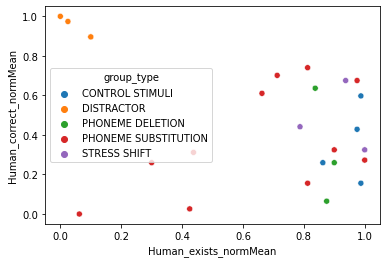

In [9]:
print("HUMAN: Effect of Comprehension on Knowledge (by Distortion Type)")
x_field = 'Human_exists_normMean'
y_field = 'Human_correct_normMean'
sns.scatterplot(data=dfs, x=x_field, y=y_field, hue='group_type')
plt.show()

VPA: Effect of Comprehension on Knowledge (with Regression)


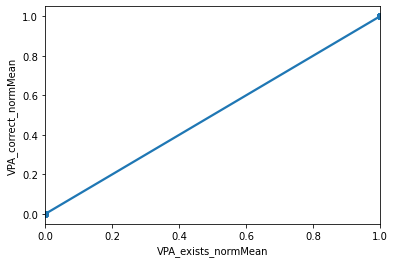

In [10]:
print("VPA: Effect of Comprehension on Knowledge (with Regression)")
x_field = 'VPA_exists_normMean'
y_field = 'VPA_correct_normMean'
sns.regplot(data=dfs, x=x_field, y=y_field)#, hue='group_type')
plt.show()

### Effect of Speech Duration on Comprehension

The charts demonstrate how...
- Humans do not need a lot of time to comprehend the question, evident from tighter and higher distributions, regardless of distortion type.
- In general (evident from the wider distributions), the VPA's comprehension suffers when the utterance is faster.
    - Note that these plots are measuring **comprehension** (measured by whether or not the listener can identify whether or not the target phrase (i.e., country) is real or not.
- Also note the differing distributions for the DISTRACTOR questions (in orange):
    - Humans are much better at identifying whether or not the country exists, but are less certain when the utterance is faster 
    - The VPA also suffers for faster utterances, but not in the same way as Humans; rather, faster utterances result in broder potential matches––a consequence of being held to produce *some* answer, rather than nothing.  

HUMAN: Speech Duration vs. Correctly Identified Country's Existence


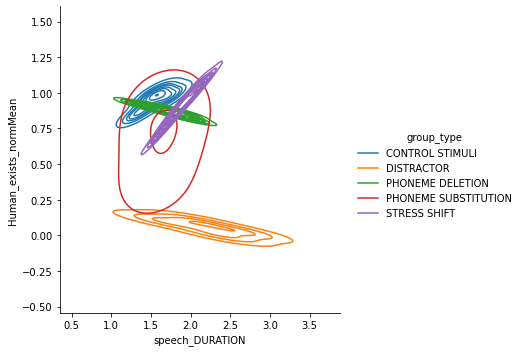

In [11]:
print("HUMAN: Speech Duration vs. Correctly Identified Country's Existence")
x_field = 'speech_DURATION'
y_field = 'Human_exists_normMean'
sns.displot(data=dfs, x=x_field, y=y_field, hue='group_type', kind='kde')
plt.show()

VPA: Speech Duration vs. Correctly Identified Country's Existence


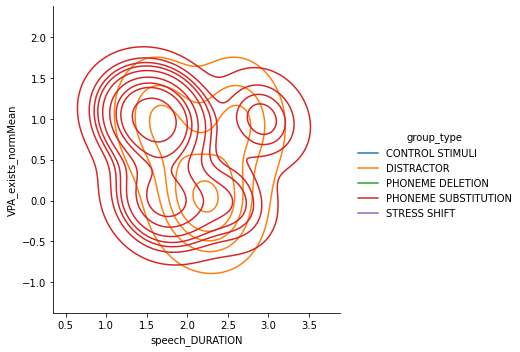

In [12]:
print("VPA: Speech Duration vs. Correctly Identified Country's Existence")
x_field = 'speech_DURATION'
y_field = 'VPA_exists_normMean'
sns.displot(data=dfs, x=x_field, y=y_field, hue='group_type', kind='kde')
plt.show()

### Comparing Distortion Type
***Finding the VPA's weakness***

#### Initial Comparison

- It is clear that Humans did best on the DISTRACTOR questions, being the only place where it beats the VPA.
    - To be fair to the VPA... *```There is no such country```* was not an option.
- The problem with normalizing data that contains such an extrame outlier (the DISTRACTOR, in this case), is that it doesn't allow us to get a better picture of the phonetic distortions.
    - For example, notice how all of the other distortion types are close together (Range: 0.32 to 0.48).

***See below***

In [13]:
dfs.groupby(by='group_type')['Human_correct_mean','VPA_correct', 'Human_correct_normMean','VPA_correct_normMean'].mean().sort_values(by=['Human_correct_mean']).dropna(how='any',axis=0)

,Human_correct_mean,VPA_correct,Human_correct_normMean,VPA_correct_normMean
group_type,,,,
PHONEME DELETION,0.340741,1.000000,0.320346,1.000000
CONTROL STIMULI,0.375000,1.000000,0.360390,1.000000
PHONEME SUBSTITUTION,0.383838,0.636364,0.370720,0.636364
STRESS SHIFT,0.477778,1.000000,0.480519,1.000000
DISTRACTOR,0.872222,0.500000,0.941558,0.500000


#### Normalized Comparison (excluding DISTRACTOR)

Here, I am excluding the DISTRACTOR distortion type, then normalizing the scores. This is to focus on phonetic effects.

**Observations**
- Notice how knowledge of the country's existence is much more competitive (relative to the VPA).
- This demonstrates that the ***lower Human scores*** for the correct answer, may not be due to Human respondents not understanding the question; rather...
    - ... it might be ***due to insufficient knowledge***.

In [16]:
# Getting relevant columns
dft = data.dfSummary[['group_type','Human_exists_mean','VPA_exists','Human_correct_mean','VPA_correct']]
# Excluding 'DISTRACTOR' distortion type
dft = dft[dft['group_type']!='DISTRACTOR']
# Normalizing data
dftt = data.getNormalized(dft, ['Human_exists_mean','VPA_exists','Human_correct_mean','VPA_correct'])
# Summarizing by Distortion Type & sorting (from Humans' worst-to-best categories)
dftg = dftt.groupby('group_type').mean().sort_values(by=['Human_correct_mean']).dropna(how='all',axis=0)
print('Normalized Scores (excluding DISTRACTOR questions)')
print('––––––––––––––––––––––––––––––––––––––––––––––––––')
dftg

Normalized Scores (excluding DISTRACTOR questions)
––––––––––––––––––––––––––––––––––––––––––––––––––


,Human_exists_mean,VPA_exists,Human_correct_mean,VPA_correct
group_type,,,,
PHONEME DELETION,0.862222,1.000000,0.432749,1.000000
CONTROL STIMULI,0.950000,1.000000,0.486842,1.000000
PHONEME SUBSTITUTION,0.621818,0.636364,0.500797,0.636364
STRESS SHIFT,0.902222,1.000000,0.649123,1.000000


##### Charting the Distribution

Human Average Score by Distortion Type


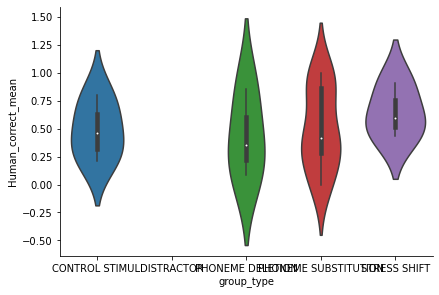

In [17]:
print('Human Average Score by Distortion Type')
ax = sns.catplot(x="group_type", y='Human_correct_mean', kind="violin", data=dftt, height=4, aspect=1.5)
plt.show()

VPA Average Score by Distortion Type


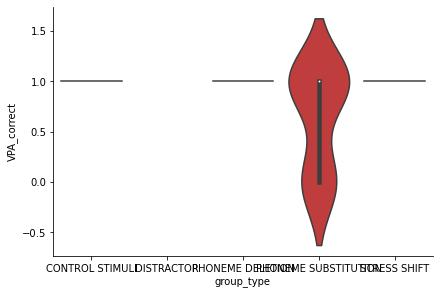

In [18]:
print('VPA Average Score by Distortion Type')
ax = sns.catplot(x="group_type", y='VPA_correct', kind="violin", data=dftt, height=4, aspect=1.5)
plt.show()

#### Leveling the Playing Field

This attempts to analyze what the difference would be if the VPA could only answer what the Humans also knew.

In [35]:
# Calculating adjustment factor for control
controlAdj_correct = dftg.loc['CONTROL STIMULI','Human_exists_mean'] / dftg.loc['CONTROL STIMULI','Human_correct_mean']
controlAdj_exists  = 1.0 / dftg.loc['CONTROL STIMULI','Human_exists_mean']
dfadj = data.dfSummary[['group_type','Human_exists_mean','VPA_exists','Human_correct_mean','VPA_correct']]
# Leveling the playing field: Adjusting VPA correct scores for Human knowledge of existence
dfadj['adj_VPA_correct'] = dfadj['VPA_correct'] * dfadj['Human_exists_mean']
# Applying adjustment to original Human mean scores (by question)
dfadj['Human_exists_mean']   = dfadj['Human_exists_mean'].multiply(controlAdj_exists)
dfadj['Human_correct_mean']  = dfadj['Human_correct_mean'].multiply(controlAdj_correct)

# Normalizing scores (without DISTRACTOR)
# dfadj = dfadj[dfadj['group_type']!='DISTRACTOR']
dfadjn = data.getNormalized(dfadj, target_columns=['Human_exists_mean','VPA_exists','Human_correct_mean','VPA_correct','adj_VPA_correct'])

# Grouping by distortion type
dfadjg = dfadjn.groupby('group_type').mean().sort_values(by=['Human_correct_mean']).dropna(how='all',axis=0)
print('Normalized Scores (VPA adjusted for Human-Knowledge basis)')
print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
dfadjg

Normalized Scores (VPA adjusted for Human-Knowledge basis)
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


,Human_exists_mean,VPA_exists,Human_correct_mean,VPA_correct,adj_VPA_correct
group_type,,,,,
PHONEME DELETION,0.870833,1.000000,0.320346,1.000000,0.881226
CONTROL STIMULI,0.953125,1.000000,0.360390,1.000000,0.956897
PHONEME SUBSTITUTION,0.645455,0.636364,0.370720,0.636364,0.466040
STRESS SHIFT,0.908333,1.000000,0.480519,1.000000,0.915709
DISTRACTOR,0.056250,0.500000,0.941558,0.500000,0.068966


##### Charting the Adjusted Distribution

*Note that this **includes** the **DISTRACTOR** questions*.

Human Average Score by Distortion Type


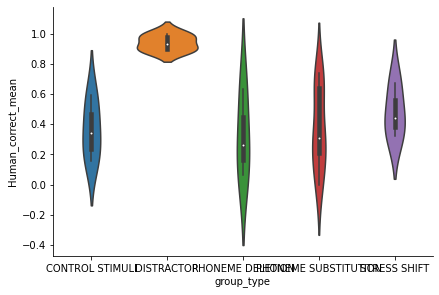

In [23]:
print('Human Average Score by Distortion Type')
ax = sns.catplot(x="group_type", y='Human_correct_mean', kind="violin", data=dfadjn, height=4, aspect=1.5)
plt.show()

VPA Human-Knowledge Adjusted Average Score by Distortion Type


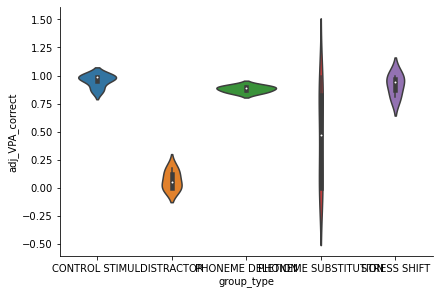

In [24]:
print('VPA Human-Knowledge Adjusted Average Score by Distortion Type')
ax = sns.catplot(x="group_type", y='adj_VPA_correct', kind="violin", data=dfadjn, height=4, aspect=1.5)
plt.show()

---

## Hypothesis

From the previous data, it is apparent that the VPA's most significant ***phonetic*** weakness is ```PHONEME SUBSTITUTION``` and the VPA's most significant ***pragmatic*** weakness is ```DISTRACTOR```; therefore, I formulate the following hypotheses:

> *Phonetic Hypothesis*
>> Virtual Personal Assistant software is more sensitive to phonetic substitution, because, as the VPA attempts to incorporate the phonetic distortion and queries its vast database, the VPA is more likely to find a closer phonetic match; whereas human speech recognition is better at inferring missing phonemes and ignoring replaced ones.

> *Pragmatic Hypothesis*
>> Humans are much better at stopping the search in their internal lexicon, ultimately being quicker and more inclined to reject potential matches; whereas the VPA continues the search and overfits the provided speech data, resulting in incorrect answers.

These hypotheses are not mutually exclusive; rather, their respective effects compound each other, synthesizing into the following hypothesis:

> **Hypothesis**
>> ***Compared to Humans, Virtual Personal Assistant software is more likely to return incorrect responses when prompted with valid pragmatic priming, but "fuzzy" target subjects (e.g., country name), particularly when the target subject is phonetically similar to a valid, non-target subject (e.g., another country).***

### Testing the Hypothesis

#### Overview
In order to maintain the integrity of the experiment (so that it may be compared to the initial results), I will use the same contextual question: "***What's/What is the capital of...***". Instead of country-to-capital queries, however, I will use state-to-capital prompts (since I already have a library installed with data for the United States).

Considering knowledge (or, rather, *access* to knowledge) is not a limitation for the VPA, the test can be considered "fair," as it still incorporates the relevant semantic priming components: 

>**Semantic Priming** in the sentence "***What's/What is the capital of...***":
- "***What is the***...": Indicates that it is an open-ended search criteria.
    - An example of a closed-ended search would be "*Is the...*", because it indidcates a binary search criteria and the expectation of more information (the name of the capital, in this case) to narrow the search.
- "... ***capital of***...": Indicates to the VPA that the target subject is a general location (e.g., country, state, etc.).

---

The **objective in creating the test stimuli** will be to exploit the hypothesized weaknesses of the VPA; therefore, I am creating stimuli wherein the target state:
1. Can be confused with another location (either a state or country), due to...
1. ... a ```PHONEME SUBSTITUTION``` that makes it more similar to other primed subjects (states, in this case).

#### Procedure

1. Calculate the similarity of each state name to every other state.
    - I'll be using Levenshtein distance to quantify similarity, of both the:
        - Orthographic spelling; and,
        - Phonetic spelling
    - For example, the state of Massachusetts would have the following spelling attributes:
    
| Orthographic | Phonetic |
| :-: | :-: |
| Massachusetts | ˌmæsəˈʧusəts |

2. Find the top 10 least-unique state names (on average).
3. Find the most similar state name for each state in the top 10 least-unique states (*calculated in Step 2*).
4. Generate a sentence for each state, distorting the target using a ```PHONEME SUBSTITUTION``` that makes the target more similar to the similarity-match.
5. Ask the VPA the generated questions.
    - Record the responses.


##### Calculating Similarities


In [25]:
# Displaying a sample
print('Example of the Levenshtein distance matrix')
print('––––––––––––––––––––––––––––––––––––––––––')
data.df_fuzzyMatrix_stateText.iloc[:5,:5]

Example of the Levenshtein distance matrix
––––––––––––––––––––––––––––––––––––––––––


,Alabama,Alaska,Arizona,Arkansas,California
Alabama,NaN,62.0,29.0,40.0,24.0
Alaska,62.0,NaN,31.0,57.0,25.0
Arizona,29.0,31.0,NaN,53.0,47.0
Arkansas,40.0,57.0,53.0,NaN,33.0
California,24.0,25.0,47.0,33.0,NaN


In [26]:
print('Least Unique States: Top 10 State names most-similar to other State names (on average)')
print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
display_side_by_side(
    data.df_fuzzyMatrix_stateText.mean().sort_values(ascending=False).head(10).to_frame().rename(columns={0:'Orthographic'}),
    data.df_fuzzyMatrix_statePhone.mean().sort_values(ascending=False).head(10).to_frame().rename(columns={0:'Phonetic'}),
)

Least Unique States: Top 10 State names most-similar to other State names (on average)
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


,Text
Montana,31.897959
California,31.530612
Minnesota,30.857143
North Carolina,30.102041
Louisiana,29.142857
South Carolina,29.020408
Arizona,28.775510
Arkansas,28.693878
Georgia,28.142857
West Virginia,28.020408


In [98]:
print('State-to-State Matches')
print('––––––––––––––––––––––')
print('        Orthographic Example  (left table): "The spelling of Montana is most similar to Indiana."')
print('            Phonetic Example (right table): "The word /Nebraska/ sounds most similar to the word /Alaska/."')
print('–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
display_side_by_side(
    data.getFuzzyTargets(data.df_fuzzyMatrix_stateText).to_frame().rename(columns={0:'Text'}),
    data.getFuzzyTargets(data.df_fuzzyMatrix_statePhone).to_frame().rename(columns={0:'Phonetic'}),
)

State-to-State Matches
––––––––––––––––––––––
        Orthographic Example  (left table): "The spelling of Montana is most similar to Indiana."
            Phonetic Example (right table): "The word /Nebraska/ sounds most similar to the word /Alaska/."
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


,,Text
South Carolina,North Carolina,86.0
North Carolina,South Carolina,86.0
West Virginia,Virginia,76.0
Arkansas,Kansas,71.0
California,Florida,59.0
Georgia,Florida,57.0
Minnesota,Maine,57.0
Montana,Indiana,57.0
Arizona,Arkansas,53.0
Louisiana,Montana,50.0


In [29]:
def phoneticOverlap(dfrow):
    target = dfrow['Phonetic Spelling: Target']
    match = dfrow['Phonetic Spelling: Match']
    unique_text = [l for l in target if (l not in match)]
    return unique_text

dfTargets = data.getFuzzyTargets(data.df_fuzzyMatrix_statePhone).to_frame().reset_index().rename(columns={'level_0':'Target','level_1':'Phonetic-Similarity Match',0:'Similarity Score'})
dfTargets['Phonetic Spelling: Target'] = dfTargets['Target'].map(data.state_text2phonetic)
dfTargets['Phonetic Spelling: Match']  = dfTargets['Phonetic-Similarity Match'].map(data.state_text2phonetic)
dfTargets['Target-Unique Phones']  = dfTargets.apply(lambda row: phoneticOverlap(row), axis=1)
dfTargets

,Target,Phonetic-Similarity Match,Similarity Score,Phonetic Spelling: Target,Phonetic Spelling: Match,Target-Unique Phones
0,Virginia,West Virginia,80.0,vərˈʤɪnjə,wɛst vərˈʤɪnjə,[]
1,Alaska,Nebraska,78.0,əˈlæskə,nəˈbræskə,[l]
2,Nebraska,Alaska,78.0,nəˈbræskə,əˈlæskə,"[n, b, r]"
3,Indiana,Louisiana,67.0,ˌɪndiˈænə,luˌiziˈænə,"[ɪ, d]"
4,Montana,Indiana,63.0,mɑnˈtænə,ˌɪndiˈænə,"[m, ɑ, t]"
5,Kansas,Texas,62.0,ˈkænzəs,ˈtɛksəs,"[æ, n, z]"
6,Arizona,Minnesota,61.0,ˌɛrɪˈzoʊnə,ˌmɪnɪˈsoʊtə,"[ɛ, r, z]"
7,Minnesota,Arizona,61.0,ˌmɪnɪˈsoʊtə,ˌɛrɪˈzoʊnə,"[m, s, t]"
8,Nevada,Nebraska,56.0,nəˈvɑdə,nəˈbræskə,"[v, ɑ, d]"
9,Illinois,California,55.0,ˌɪləˈnɔɪ,ˌkæləˈfɔrnjə,"[ɪ, ɪ]"


----
#### Test Stimuli

The following sentences will be used to test the VPA:

1. What is the capital of **Virginia**?
    - What is the capital of **/wɔˌərˈʤɪnjə/**?
1. What is the capital of **Alaska**?
    - What is the capital of **/əˈbræskə/**?
1. What is the capital of **Nebraska**?
    - What is the capital of **/nəˈlæskə/**?
1. What is the capital of **Indiana**?
    - What is the capital of **/luˌɪniˈænə/**?
1. What is the capital of **Montana**?
    - What is the capital of **/ˌmɑnˈænə/**?
1. What is the capital of **Kansas**?
    - What is the capital of **/ˈkæn-ksəs/**?
1. What is the capital of **Arizona**?
    - What is the capital of **/ˌɛrɪ-ˈsoʊtə/**?
1. What is the capital of **Minnesota**?
    - What is the capital of **/ˌmɪnˈzoʊnə/**?
1. What is the capital of **Nevada**?
    - What is the capital of **/nəˈvædskə/**?
1. What is the capital of **Illinois**?
    - What is the capital of **/ˌkælˈˌɪləˈnɔɪ/**?

----

How similar do these new *distorted* words sound? To attempt to quantify their expected similarity, let's compare the phonetic spellings of the distortions to the phonetic spellings of the targets and their phonetic-matches:
- The two relevant columns here are:
    - **```Distortion Similarity: Target```**: How similar the Target state sounds to the expected sound of the distorted word.
    - **```Distortion Similarity: Match```**: How similar the Match state (i.e., the state that is most-phonetically-similar to the Target state) sounds to the expected sound of the distorted word.
- In some cases, the Match-similarity is higher than the Target-similarity. The expectation, in this case, is that the VPA will identify those phonemes, and *incorrectly* return the capital of the Match state. Examples of this include:

| Target State | Match State | Target-to-Distortion Similarity | Match-to-Distortion Similarity | VPA's Expected Answer |
|--:|:--|--:|:--|:-:|
| Alaska | Nebraska | 75 | 89 | Lincoln |
| Nebraska | Alaska | 78 | 88 | Juneau |
| Minnesota | Arizona | 73 | 76 | Phoenix |
| Nevada | Nebraska | 71 | 74 | Lincoln |


In [99]:
stimuli_target2distortion = {
    "Virginia"  : "wɔˌərˈʤɪnjə",
    "Alaska"    : "əˈbræskə",
    "Nebraska"  : "nəˈlæskə",
    "Indiana"   : "luˌɪniˈænə",
    "Montana"   : "ˌmɑnˈænə",
    "Kansas"    : "ˈkæn-ksəs",
    "Arizona"   : "ˌɛrɪ-ˈsoʊtə",
    "Minnesota" : "ˌmɪnˈzoʊnə",
    "Nevada"    : "nəˈvædskə",
    "Illinois"  : "ˌkælˈˌɪləˈnɔɪ",
}

dfDist = dfTargets[['Target', 'Phonetic Spelling: Target','Phonetic-Similarity Match','Phonetic Spelling: Match']]
dfDist['Distorted Target'] = dfDist['Target'].map(stimuli_target2distortion)
dfDist['Distortion Similarity: Target'] = dfDist.apply(lambda row: fuzz.ratio(row['Phonetic Spelling: Target'], row['Distorted Target']), axis=1)
dfDist['Distortion Similarity: Match']  = dfDist.apply(lambda row: fuzz.ratio(row['Phonetic Spelling: Match'], row['Distorted Target']), axis=1)
print('New Stimuli – Distortion Similarity Comparison')
print('––––––––––––––––––––––––––––––––––––––––––––––')
dfDist

New Stimuli – Distortion Similarity Comparison
––––––––––––––––––––––––––––––––––––––––––––––


,Target,Phonetic Spelling: Target,Phonetic-Similarity Match,Phonetic Spelling: Match,Distorted Target,Distortion Similarity: Target,Distortion Similarity: Match
0,Virginia,vərˈʤɪnjə,West Virginia,wɛst vərˈʤɪnjə,wɔˌərˈʤɪnjə,76,69
1,Alaska,əˈlæskə,Nebraska,nəˈbræskə,əˈbræskə,75,89
2,Nebraska,nəˈbræskə,Alaska,əˈlæskə,nəˈlæskə,78,88
3,Indiana,ˌɪndiˈænə,Louisiana,luˌiziˈænə,luˌɪniˈænə,80,76
4,Montana,mɑnˈtænə,Indiana,ˌɪndiˈænə,ˌmɑnˈænə,82,67
5,Kansas,ˈkænzəs,Texas,ˈtɛksəs,ˈkæn-ksəs,71,59
6,Arizona,ˌɛrɪˈzoʊnə,Minnesota,ˌmɪnɪˈsoʊtə,ˌɛrɪ-ˈsoʊtə,73,70
7,Minnesota,ˌmɪnɪˈsoʊtə,Arizona,ˌɛrɪˈzoʊnə,ˌmɪnˈzoʊnə,73,76
8,Nevada,nəˈvɑdə,Nebraska,nəˈbræskə,nəˈvædskə,71,74
9,Illinois,ˌɪləˈnɔɪ,California,ˌkæləˈfɔrnjə,ˌkælˈˌɪləˈnɔɪ,73,54


## Stimuli Test Results

Over three trials (per stimulus), the results proved similar to the *Human-Knowledge Adjusted* score for ```PHONEME SUBSTITUTION``` in the original tests:

| VPA Test | Average Score: ```PHONEME SUBSTITUTION``` |
|--:|:-:|
| Initial | 0.636364 |
| Human-Knowledge Adj. | 0.466040 |
| ***Test Stimuli*** | **0.466667** |

In [100]:
dfStimResults = data.analyze_VPA_Results()
print('VPA Stimuli Test Results')
print('–––––––––––––––––––––––––––')
print('    Average Score:', '{:.6f}'.format(dfStimResults['VPA_score_mean'].mean()))
dfStimResults

VPA Stimuli Test Results
–––––––––––––––––––––––––––
    Average Score: 0.466667


,Target,Phonetic-Similarity Match,Phonetic Spelling: Target,Phonetic Spelling: Match,Distorted Target,VPA_answer_trial1,VPA_answer_trial2,VPA_answer_trial3,Target_capital,VPA_score_mean
0,Virginia,West Virginia,vərˈʤɪnjə,wɛst vərˈʤɪnjə,wɔˌərˈʤɪnjə,Richmond,Richmond,Richmond,Richmond,1.000000
1,Alaska,Nebraska,əˈlæskə,nəˈbræskə,əˈbræskə,Lincoln,Lincoln,Lincoln,Juneau,0.000000
2,Nebraska,Alaska,nəˈbræskə,əˈlæskə,nəˈlæskə,Juneau,Juneau,Juneau,Lincoln,0.000000
3,Indiana,Louisiana,ˌɪndiˈænə,luˌiziˈænə,luˌɪniˈænə,Indianapolis,Indianapolis,Baton Rouge,Indianapolis,0.666667
4,Montana,Indiana,mɑnˈtænə,ˌɪndiˈænə,ˌmɑnˈænə,Augusta,NaN,NaN,Helena,0.000000
5,Kansas,Texas,ˈkænzəs,ˈtɛksəs,ˈkæn-ksəs,Topeka,Topeka,Topeka,Topeka,1.000000
6,Arizona,Minnesota,ˌɛrɪˈzoʊnə,ˌmɪnɪˈsoʊtə,ˌɛrɪ-ˈsoʊtə,Phoenix,Phoenix,Phoenix,Phoenix,1.000000
7,Minnesota,Arizona,ˌmɪnɪˈsoʊtə,ˌɛrɪˈzoʊnə,ˌmɪnˈzoʊnə,Augusta,Saint Paul,Augusta,Saint Paul,0.333333
8,Nevada,Nebraska,nəˈvɑdə,nəˈbræskə,nəˈvædskə,Carson City,Carson City,Lincoln,Carson City,0.666667
9,Illinois,California,ˌɪləˈnɔɪ,ˌkæləˈfɔrnjə,ˌkælˈˌɪləˈnɔɪ,Sacramento,Sacramento,NaN,Springfield,0.000000


### Relationship Analysis: *Phonetic Similarity vs. VPA Score*

In order to analyze the effect of the distortions on the VPA's score, I calculated the ratio of the ```Distortion Similarity: Target``` (the distorted phonetic word vs. the Target phonetic state) and ```Distortion Similarity: Match``` (the distorted phonetic word vs. the closest phonetic state): **```distortionRatio_target2match```**


\begin{align}
  \text{distortionRatio_target2match} &= \frac{\text{Distortion Similarity: Target}}{\text{Distortion Similarity: Match}} \\
    &= \frac{\text{PhoneticSimilarity(Target, Distorted Stimuli)}}{\text{PhoneticSimilarity(Match, Distorted Stimuli)}} \\
\end{align}


If **```distortionRatio_target2match```** is...
- **> 1**:
    - The distorted word is **more phonetically similar to the Target state**, versus the Match state.
- **= 1**:
    - The distorted word is **equally as phonetically similar** to the **Target state** ***and*** the **Match state**
- **< 1**:
    - The distorted word is **more phonetically similar to the Match state**, versus the Target state.

*See the following table for reference...*

In [80]:
df_distRel = dfDist.set_index('Target')[['Distortion Similarity: Target', 'Distortion Similarity: Match']].rename(columns={
    'Distortion Similarity: Target':'sim_dist2target',
    'Distortion Similarity: Match':'sim_dist2match',
})
df_distRel['VPA_score_mean'] = dfStimResults.set_index('Target')['VPA_score_mean']
df_distRel['distortionRatio_target2match'] = df_distRel['sim_dist2target'] / df_distRel['sim_dist2match']
df_distRel['The Distorted word is more similar to the...'] = np.where(df_distRel['distortionRatio_target2match']>1,'Target state','Match state')
df_distRel

,sim_dist2target,sim_dist2match,VPA_score_mean,distortionRatio_target2match,The Distorted word is more similar to the...
Target,,,,,
Virginia,76,69,1.000000,1.101449,Target state
Alaska,75,89,0.000000,0.842697,Match state
Nebraska,78,88,0.000000,0.886364,Match state
Indiana,80,76,0.666667,1.052632,Target state
Montana,82,67,0.000000,1.223881,Target state
Kansas,71,59,1.000000,1.203390,Target state
Arizona,73,70,1.000000,1.042857,Target state
Minnesota,73,76,0.333333,0.960526,Match state
Nevada,71,74,0.666667,0.959459,Match state


#### Charting the Relationship: *Phonetic Similarity vs. VPA Score*

Note that a *2-order polynomial regression* is used, to account for the fact that both states' similarities can be very similar (i.e., more positive on the x-axis), but they can be so similar that the VPA has a difficult time distinguishing between the two.
- Of course, by this logic, the ratio could also represent that both states' similarities are extremely different from the stimulus, but to the same degree; however, since the phonetic stimulus was constructed off of the target and match words, this is less likely. 
---
An interesting phenomena can be observed here:
- The VPA is performs well when the Target is distorted marginally more (relative to the Match)...
    - ... but only up to an extent, apexing around 1.1 (i.e., when the Target is 10% more similar to the Distorted word, than the Match)
    - This may be due to the new Distorted word being more similar to a state *other* than the Match state (which was the case with the stimulus for Minnesota, which interpreted the utterance as "Maine", thus, returning "Augusta".

VPA: Effect of Phonetic Similarity on Score


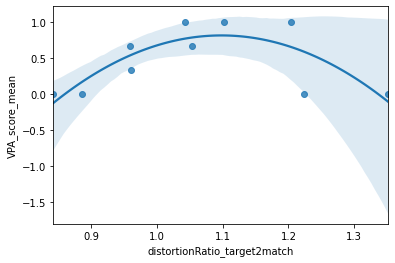

In [176]:
print("VPA: Effect of Phonetic Similarity on Score")
x_field = 'distortionRatio_target2match'
y_field = 'VPA_score_mean'
sns.regplot(data=df_distRel, x=x_field, y=y_field, order=2)
# sns.displot(data=df_distRel, x=x_field, y=y_field, hue='The Distorted word is more similar to the...', kind='kde')
plt.show()

VPA: Target-to-Distortion Similarity vs. VPA Score


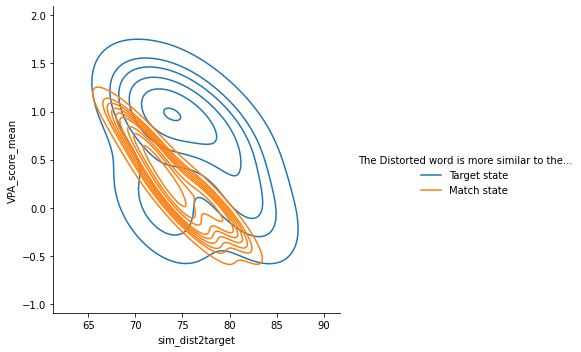

In [177]:
print("VPA: Target-to-Distortion Similarity vs. VPA Score")
x_field = 'sim_dist2target'
y_field = 'VPA_score_mean'
# sns.regplot(data=df_distRel, x=x_field, y=y_field, order=2)
sns.displot(data=df_distRel, x=x_field, y=y_field, hue='The Distorted word is more similar to the...', kind='kde')
plt.show()

VPA: Match-to-Distortion Similarity vs. VPA Score


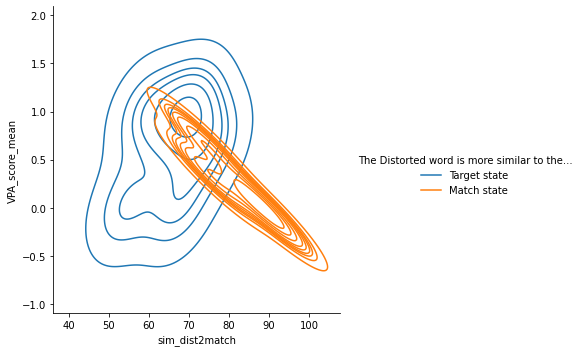

In [178]:
print("VPA: Match-to-Distortion Similarity vs. VPA Score")
x_field = 'sim_dist2match'
y_field = 'VPA_score_mean'
# sns.regplot(data=df_distRel, x=x_field, y=y_field, order=2)
sns.displot(data=df_distRel, x=x_field, y=y_field, hue='The Distorted word is more similar to the...', kind='kde')
plt.show()

---

### Hypothesis Results

For reference, here is my original hypothesis, rephrased for the context of the test stimuli (i.e., "state" instead of "country"):

> **Hypothesis**
>> ***Compared to Humans, Virtual Personal Assistant software is more likely to return incorrect responses when prompted with valid pragmatic priming, but "fuzzy" target subjects (e.g., state name), particularly when the target subject is phonetically similar to a valid, non-target subject (e.g., another state).***

| Hypothesis | Description |
|:-:|:--|
| $H_{0}$ | VPA_score == average(VPA_score of all other distortion types, excluding DISTRACTOR) |
| $H_{A}$ | VPA_score != average(VPA_score of all other distortion types, excluding DISTRACTOR) |

    
*See [Appendix](#Appendix) below for the appropriate [t-Tests](#t-Test-Results)...*


## Conclusion

I believe my hypothesis is supported, not only in light of the statistical tests, but because it is intuitive that, given certain priming factors, the VPA would seek out similar sounding locations, based on their phonetic composition.

When watching Siri's translation of the recordings (at the bottom of the screen), every time it clearly writes out "What is the capital of...", then, when saying the Distorted word, it would type out its translation of the first syllable, then once the second syllable is spoken, it would adjust its first syllable-translation and proceed. One observation I did not document, however, was evidence that Siri strongly weights consonants when editing its translations of past syllables; an interesting test would be to test its performance on ```PHONEME DELETION``` stimuli with all consonants removed in state's name, as well as with the names' vowels removed. Comparing both tests may provide insight into how much the VPA uses each as a determinant.

The reason ```PHONEME SUBSTITUTION``` successfully disrupts the VPA's logic (and may not disrupt as much for some of the other distortion types), is because the replaced phonemes add a whole new factor, rather than merely ommitting factors:
- If the phoneme is omitted, then the VPA has the liberty to "fill in the blanks"
- If the phoneme is replaced, then the VPA has to take this new phoneme into account, and make the active decision to ignore it or find its intended match––in both cases, deviating from the user's explicit input.

One factor I did not test was the location of the substitution (like in the original test); this was primarily because there were not enough observations in the original test to which I could compare for the new one, and more than 10 stimuli would be needed to accurately assess the effect of positioning on the VPA's performance. It would make sense that more substitutions would result in more errors, but for single-substitution stimuli, my test can only support that consonant-substitution would have the most significant impact.






## Appendix

### t-Test Results

In [161]:
mean1 = dfs[(dfs['group_type']!='PHONEME SUBSTITUTION')&((dfs['group_type']!='DISTRACTOR'))]['VPA_correct'].mean()
std1 = dfs[(dfs['group_type']!='PHONEME SUBSTITUTION')&((dfs['group_type']!='DISTRACTOR'))]['VPA_correct'].std()
nobs1 = dfs[(dfs['group_type']!='PHONEME SUBSTITUTION')&((dfs['group_type']!='DISTRACTOR'))]['VPA_correct'].count()

mean2 = dfs[dfs['group_type']=='PHONEME SUBSTITUTION']['VPA_correct'].mean()
std2 = dfs[dfs['group_type']=='PHONEME SUBSTITUTION']['VPA_correct'].std()
nobs2 = dfs[dfs['group_type']=='PHONEME SUBSTITUTION']['VPA_correct'].count()

ttest_initial = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)

print('t-Test Results: PHONEME SUBSTITUTION vs. All Other Distortion Types (initial data)')
print('    Answers: "Is PHONEME SUBSTITUTION a particular weakspot for VPAs?"')
print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
print(' t-Stat: ', ttest_initial.statistic)
print('p-value: ', ttest_initial.pvalue)
print('================================')
if ttest_initial.pvalue<0.05:
    print('Yes (p-value<0.05): PHONEME SUBSTITUTION is a weakspot for VPAs.')
else:
    print('No (p-value>=0.05): PHONEME SUBSTITUTION is not a weakspot for VPAs.')


t-Test Results: PHONEME SUBSTITUTION vs. All Other Distortion Types (initial data)
    Answers: "Is PHONEME SUBSTITUTION a particular weakspot for VPAs?"
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 t-Stat:  2.2737783592977756
p-value:  0.03476790262036475
Yes (p-value<0.05): PHONEME SUBSTITUTION is a weakspot for VPAs.


In [162]:
mean3 = df_distRel['VPA_score_mean'].mean()
std3  = df_distRel['VPA_score_mean'].std()
nobs3 = df_distRel['VPA_score_mean'].count()

ttest_stimuli = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean3, std3, nobs3)

print('t-Test Results: PHONEME SUBSTITUTION vs. All Other Distortion Types (new data)')
print('    Answers: "Does the new data (from the test stimuli',
      '\n              support the previous findings (that PHONEME SUBSTITUTION',
      '\n              a particular weakspot for VPAs)?"')
print('––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
print(' t-Stat: ', ttest_stimuli.statistic)
print('p-value: ', ttest_stimuli.pvalue)
print('================================')
if ttest_stimuli.pvalue<0.05:
    print('Yes (p-value<0.05): PHONEME SUBSTITUTION is a weakspot for VPAs.')
else:
    print('No (p-value>=0.05): PHONEME SUBSTITUTION is not a weakspot for VPAs.')


t-Test Results: PHONEME SUBSTITUTION vs. All Other Distortion Types (new data)
    Answers: "Does the new data (from the test stimuli 
              support the previous findings (that PHONEME SUBSTITUTION 
              a particular weakspot for VPAs)?"
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 t-Stat:  3.748170285326545
p-value:  0.0014719317164072325
Yes (p-value<0.05): PHONEME SUBSTITUTION is a weakspot for VPAs.


In [164]:
ttest_initial2stimuli = stats.ttest_ind_from_stats(mean2, std2, nobs2, mean3, std3, nobs3)

print('t-Test Results for PHONEME SUBSTITUTION: Initial Data vs. Test Stimuli')
print('    Answers: Are the new test results in line with the initial results?')
print('             In other words... were the two tests comparable?')
print('–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')
print(' t-Stat: ', ttest_initial2stimuli.statistic)
print('p-value: ', ttest_initial2stimuli.pvalue)
print('================================')
if ttest_initial2stimuli.pvalue>=0.05:
    print('Yes (p-value>=0.05): The effect of phoneme substitution on the VPA was similar in both tests.')
else:
    print('No (p-value<0.05): The effect was not similar.')


t-Test Results for PHONEME SUBSTITUTION: Initial Data vs. Test Stimuli
    Answers: Are the new test results in line with the initial results?
             In other words... were the two tests comparable?
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 t-Stat:  0.8100509533506889
p-value:  0.42794044116449215
Yes (p-value>=0.05): The effect of phoneme substitution on the VPA was similar in both tests.
